In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

print("TF  Version",tf.__version__)

TF  Version 2.4.0


## Load Data

In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
DATA_DIR = DIR + "brdd/xAI_stroke_3d/data/"

version = "10Fold_sigmoid_V3" # one of:
# 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

if version.startswith("10Fold"):
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/" + version + "/"
    OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/" + version + "/"
    pic_save_name = "10Fold_ensembling" + version[6:]
    
elif version == "andrea":
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/weights/andrea_split/"
    OUTPUT_DIR = "/tf/notebooks/brdd/xAI_stroke_3d/pictures/andrea_split/"
    pic_save_name = "andrea_split"

/tf/notebooks/brdd/xAI_3d


In [3]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold       
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
        num_models = 10
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
        num_models = 5
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
        num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [4]:
split_6_pats = [297, 299, 319, 460, 483, 529, 27, 35, 125, 481]

## Model

In [5]:
# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [6]:
# Define Model Name
def generate_model_name(which_split, model_nr, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_1" + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_1" + str(model_nr) + ".h5")

# Plot GradCams

## Compare one Model to all Models

In [7]:
# all_results

In [8]:
# select patient
p_ids = [12]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in, 
                                                                 gen_model_name = generate_model_name,
                                                                 num_models = num_models)
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,126,8,12,1.0,0,train,train,train,test,train,...,0.030124,0.020293,0.037173,0.02948,0.028111,0.179302,0,0.009987,0.034058,True


In [9]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

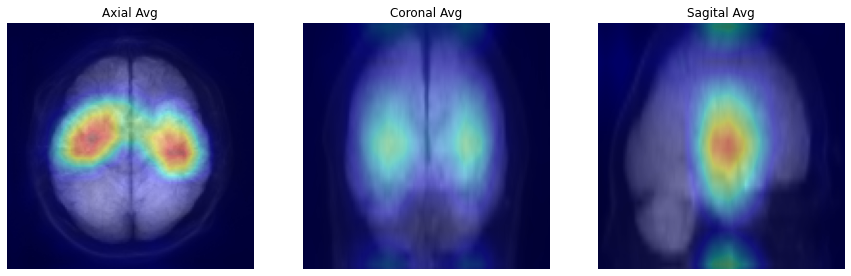

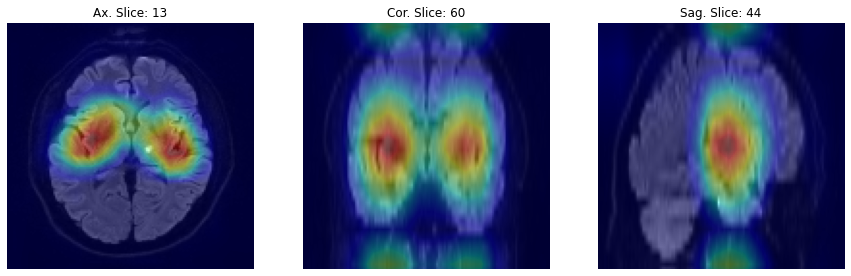

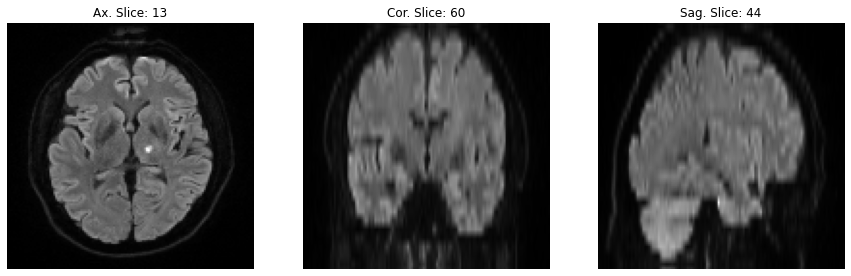

In [10]:
# only one model
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][1]],
    layers = "conv3d_3",
#     layers = vis_layers,
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

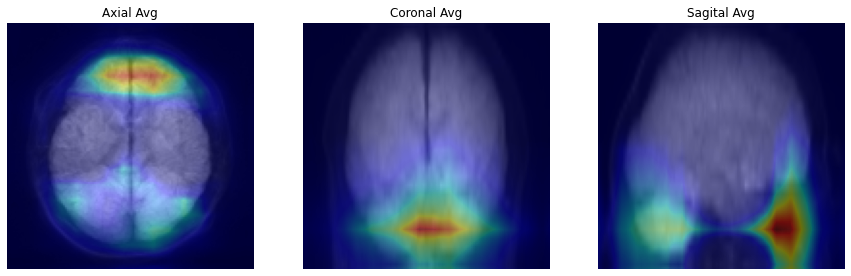

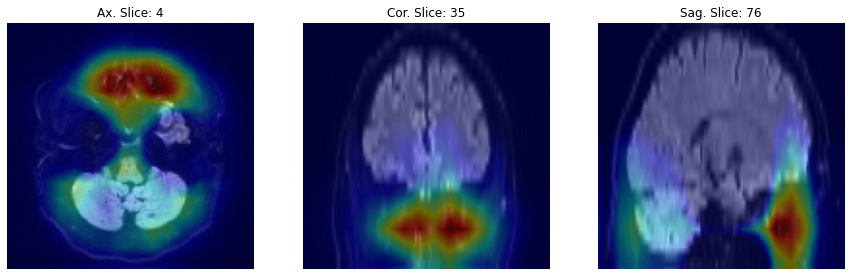

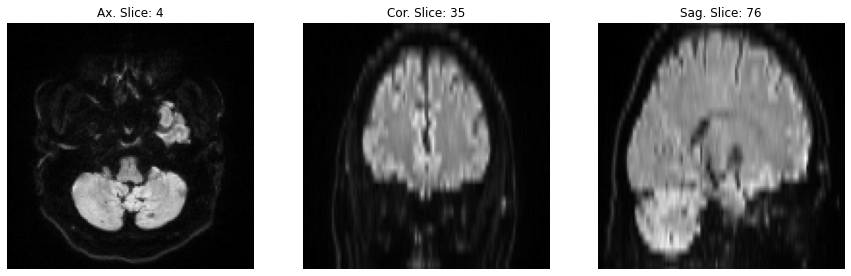

In [12]:
# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[-1],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "none")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

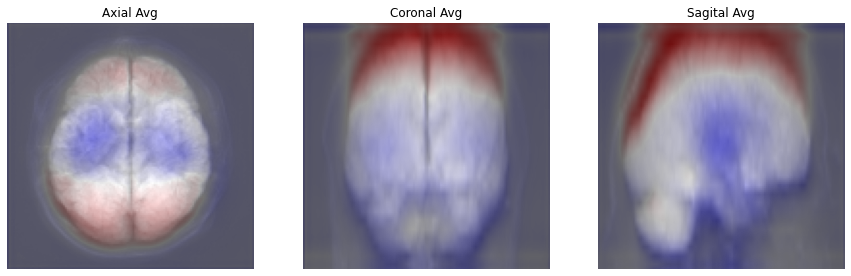

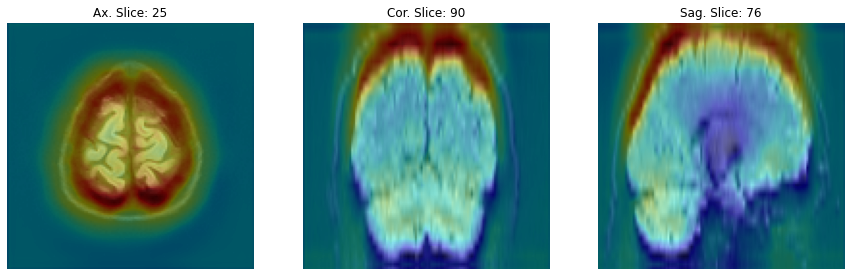

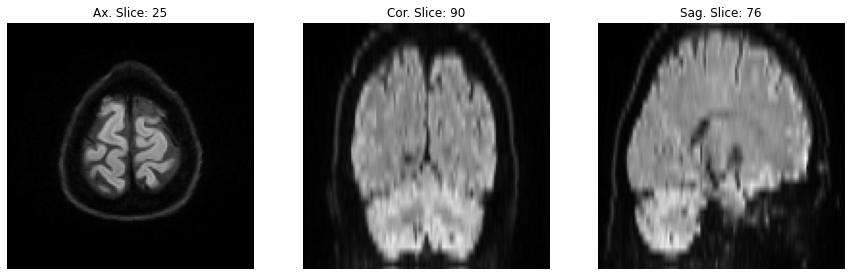

In [134]:
from importlib import reload
reload(pgc)
reload(gc)

# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers,
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "none",
    gcpp_hm="none")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

In [ ]:
-0.1 /1e-100

## Model Uncertainty Heatmap

In [ ]:
heatmaps = []
for i in range(5):
    heatmap0, resized_img, max_hm_slice0, hm_mean_std0 = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][i]],
    layers = "conv3d_3",
    model_mode = "mean")
    print(np.unravel_index(np.argmax(heatmap0), heatmap0.shape))
    heatmaps.append(heatmap0)
heatmaps = np.array(heatmaps)
heatmaps.shape
heatmap_var = np.var(heatmaps, axis = 0)
print(np.sqrt(np.mean(heatmap_var)))

In [ ]:
pgc.plot_gradcam(resized_img, heatmap_var,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap_var,
            version = "overlay",
            mode = "max")
# pgc.plot_gradcam(resized_img, heatmap,
#             version = "original",
#             mode = "max")

In [ ]:
from skimage.metrics import structural_similarity, mean_squared_error, normalized_root_mse

mse = []
ssim = []

for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
        mse.append(mean_squared_error(heatmaps[i].squeeze(), heatmaps[j].squeeze()))
        ssim.append(structural_similarity(heatmaps[i].squeeze(), heatmaps[j].squeeze(), data_range=1, multichannel = False))
        
print(np.array(mse).reshape((5,5)))
print(np.array(ssim).reshape((5,5)))

## Plot multiple Layers

In [ ]:
# select patient
p_ids = [12]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

In [ ]:
model_mode = "mean"
layer_mode = "mean"
invert_hm = "last"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

if "sigmoid" in str(model_3d.layers[-1].activation):
        pred_idx = 0
elif "softmax" in str(model_3d.layers[-1].activation):
        pred_idx = 1

for j in range(len(res_table)):   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+5/num_rows/15, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+4/num_rows/15, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+3/num_rows/15, "true class: " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/15, "pred prob (class 1):  " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/15, "pred class:  " + str(res_table["y_pred_class"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layer,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm)
        
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        pgc.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    # average over all layers
    heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    if save_plot:
        plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_' + pic_save_name + '_all_conv_layers.png')


## Plot last conv and average of conv layer

Same style as PowerPoint

In [ ]:
all_results

In [ ]:
# select patient
# p_ids = [6]
p_ids = split_6_pats

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version == "10Fold":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # 10 Fold

if save_plot:
    res_table[["p_id", "mrs", "unfavorable", "test_split", "y_pred_model_10", 
               "y_pred_model_11", "y_pred_model_12", "y_pred_model_13", "y_pred_model_14", 
               "y_pred_trafo_avg", "threshold", "y_pred_class", "y_pred_unc"]].to_csv(
        OUTPUT_DIR + "andrea_split6_meta_data.csv",  index=False)

In [ ]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

In [ ]:
res_table

In [ ]:
pgc.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "avg", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

In [ ]:
pgc.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "max", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

## Analysis of Patients in multiple splits

In [ ]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup

In [ ]:
p_ids = [9,24]

In [ ]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)

In [ ]:
res_table

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[1], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[1],
    layers = "conv3d_3",
    model_mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

## Analyze Image "Impurity"

In [ ]:
p_ids = [6]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

In [ ]:
new_img = res_images[0].copy()
print(new_img.min(), new_img.max())
new_img[45:60,45:60,10:15] = 8
# new_img[10:20,10:20,10:15] = 4
# new_img += 3

In [ ]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(new_img, axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
pgc.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
pgc.plot_gradcam(resized_img, heatmap,
            version = "activation",
            mode = "avg")